In [2]:
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import os
import math
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
load_app_config()
DIRECTORY = "titanic"
TRAINFILENAME = "train.csv"
TESTFILENAME = "test.csv"
FILENAME ='titanic.csv'
ALL_COLUMNS = ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
               'Embarked']

X_COLUMNS = ['Fare', 'Pclass', 'Sex_Bin', 'Age', 'SibSp']
Y_COLUMNS = ['Survived']
TRAINING_MODE =True
input_path = get_datafolder_path()

In [4]:
def start_classification(dc_model ,filename=FILENAME, is_training=True):
    
    print("start_classification")
    
    input_file = os.path.join(input_path, DIRECTORY, filename)

    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    
    train=input_dataset.sample(frac=0.8,random_state=1)
    display_dataset_info(train)
    
    test=input_dataset.drop(train.index)
     
    train_y =train['Survived']
    train = train.drop(['Survived'],axis=1)
    train_X =clean_dataset(train)[X_COLUMNS]
    train_model(dc_model,train_X,train_y)
    
    #display_dataset_info(test)
    test_y =test['Survived']
    test = test.drop(['Survived'],axis=1)
    test_X =clean_dataset(test)[X_COLUMNS]
    test_model(dc_model,test_X,test_y,test,filename)
    
    return True
    
def train_model(dc_model,train_X,train_y):
    
    dc_model.fit(train_X,train_y)
    acc_decision_tree = round(dc_model.score(train_X, train_y), 4)
    print("Training Accuracy: %0.4f" % (acc_decision_tree))

def test_model(dc_model,test_X,test_y,test,filename):
    test_set =pd.DataFrame(test_X,columns=X_COLUMNS)
    print(test_set.head(5))
    print("Test Size {0}".format(test_set.shape))
    
    FORMAT = '%Y%m%d%H%M%S'
    timestamp=datetime.datetime.now().strftime(FORMAT)
    filename_appender ="_"+timestamp+"_out.csv"
    out_filename =os.path.join(input_path, DIRECTORY, filename.replace(".csv",filename_appender))

    print("Predictions are written to  {0}".format(out_filename))
    predict_y = dc_model.predict(test_X)
    
    print("Accuracy is ", accuracy_score(test_y,predict_y)*100)
    from sklearn.metrics import confusion_matrix
    pd.DataFrame(
    confusion_matrix(test_y, predict_y),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival'])
    
    test["Survived"] =test_y
    test["Predict_Survived"] =predict_y
    test['Prediction_Result'] = np.where(test['Survived'] ==test['Predict_Survived']  , 'CORRECT', 'INCORRECT')
    
    test.to_csv(out_filename,index = False)
    from sklearn.metrics import confusion_matrix
    print(pd.DataFrame(
    confusion_matrix(test_y, predict_y),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
    ))
    
def visualize_dataset(input_dataset):
    continuous_vars = input_dataset.describe().columns
    categorical_vars = input_dataset.describe(include=["object"]).columns
    input_dataset.hist(column=continuous_vars, figsize = (16,16))
    fig, axes = plt.subplots(4, 3, figsize=(16, 16))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)
    for i, ax in enumerate(axes.ravel()):
        if i > 9:
            ax.set_visible(False)
            continue
        sns.countplot(y = categorical_vars[i], data=input_dataset, ax=ax)
    
     
    
def learn_model(dc_model,input_dataset_cleaned):
    X_values = input_dataset_cleaned[X_COLUMNS]
    y_values = input_dataset_cleaned[Y_COLUMNS]
    dc_model.fit(X_values,y_values)


def display_dataset_info(input_dataset):
    print(input_dataset.info())
     
    #print(input_dataset.head(4).to_string())
    #print(input_dataset.head(4))
    #print("Data set counts:")
    #print(input_dataset.count())

def clean_dataset(input_dataset):
    columns_to_dropped = ['Cabin', 'Ticket']
    process_dataset = input_dataset.drop(columns_to_dropped, axis=1)
    class_le = LabelEncoder()
    class_lb = LabelBinarizer()
    sex_bin = class_lb.fit_transform(process_dataset['Sex'].values)
    process_dataset['Sex_Bin'] = sex_bin

    mean_age = math.ceil(process_dataset["Age"].mean())
    # print("average age {0}".format(mean_age))
    process_dataset["Age"] = process_dataset["Age"].fillna(mean_age)
    process_dataset["Embarked"] = process_dataset["Embarked"].fillna("NA")
    Embarked_EC = class_le.fit_transform(process_dataset["Embarked"])

    process_dataset["Embarked_EC"] = Embarked_EC

    median_fare = math.ceil(process_dataset["Fare"].median())
    process_dataset["Fare"] = process_dataset["Fare"].fillna(median_fare)
    # print("age {0}".format(process_dataset["Age"].unique()))
    return process_dataset

In [5]:
#dc_model = DecisionTreeClassifier(max_depth=5 ,random_state=1)
dc_model = DecisionTreeClassifier(criterion = "entropy",max_depth=5 ,random_state=1)
start_classification(dc_model,FILENAME,TRAINING_MODE)
input_path = get_datafolder_path()
out_dot_file =os.path.join(input_path, DIRECTORY, FILENAME.replace(".csv","_out.dot"))
print(out_dot_file)

 


start_classification
 input file is :D:\DataSource\titanic\titanic.csv loaded.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 201 to 781
Data columns (total 11 columns):
Pclass      1047 non-null int64
Survived    1047 non-null int64
Name        1047 non-null object
Sex         1047 non-null object
Age         837 non-null float64
SibSp       1047 non-null int64
Parch       1047 non-null int64
Ticket      1047 non-null object
Fare        1046 non-null float64
Cabin       242 non-null object
Embarked    1045 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 98.2+ KB
None
Training Accuracy: 0.8357
        Fare  Pclass  Sex_Bin   Age  SibSp
15   25.9250       1        1  31.0      0
20   52.5542       1        1  37.0      1
21   52.5542       1        0  47.0      1
24  221.7792       1        0  29.0      0
25   26.0000       1        1  25.0      0
Test Size (262, 5)
Predictions are written to  D:\DataSource\titanic\titanic_20191105211121_out.csv
Ac

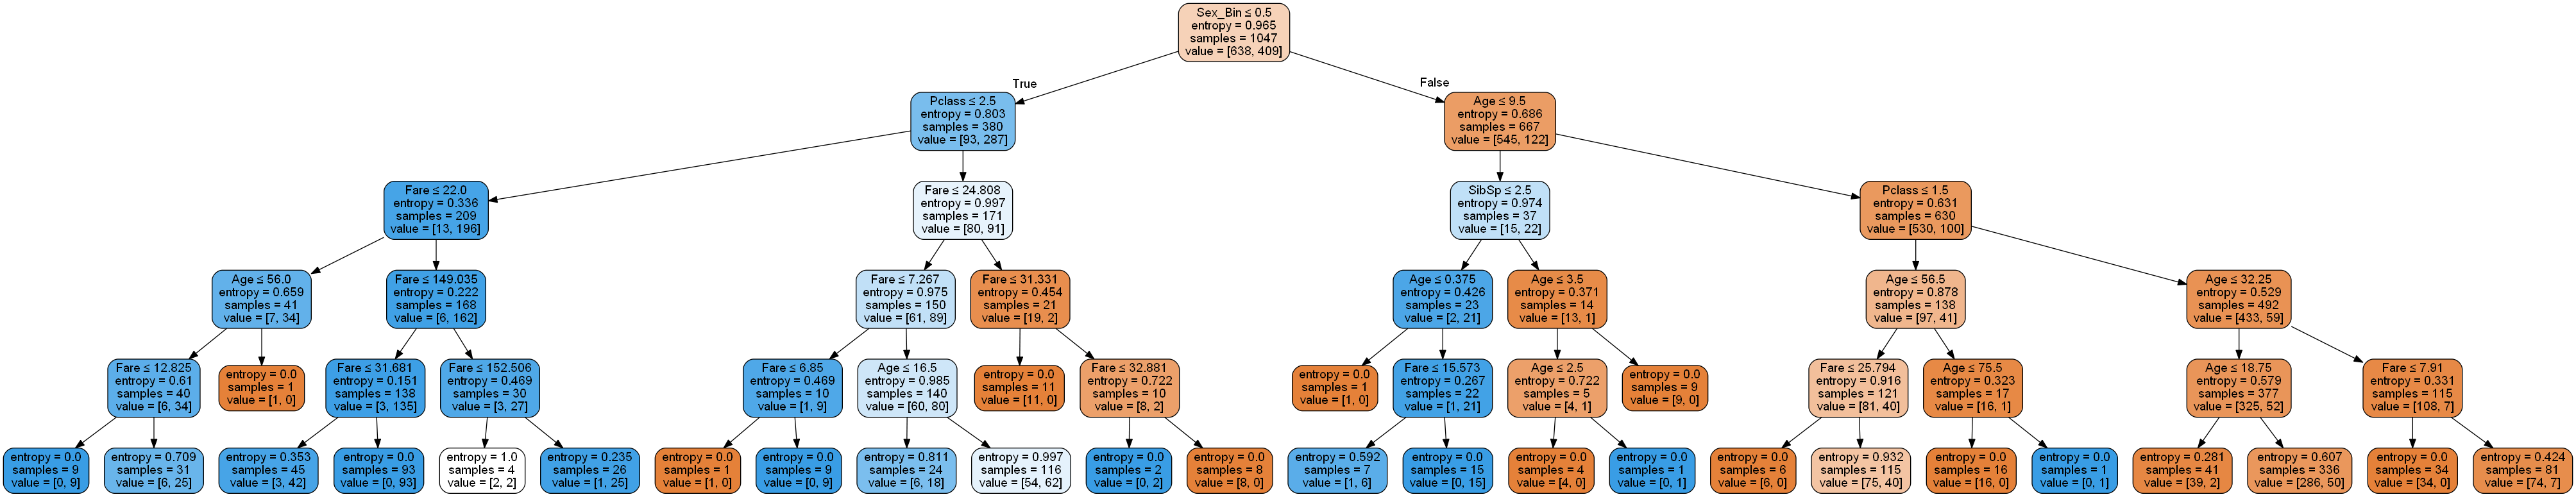

In [11]:
from IPython.display import Image  
#from sklearn.externals.six import StringIO  
import io
import pydotplus 
from sklearn import tree

dot_data = io.StringIO()  
tree.export_graphviz(dc_model, out_file=dot_data,  
                         feature_names=X_COLUMNS,filled=True,rounded =True,special_characters=True)  
#print(dot_data.getvalue())
graph = pydotplus.graphviz.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
